In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import pandas as pd
import numpy as np
import unicodedata

# Step 1. 데이터 준비
---

In [2]:
import os
file_path = os.getenv('HOME') +'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng','fra','cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5)

전체 샘플의 수 : 217975


,eng,fra,cc
96488,I find you very attractive.,Je te trouve très attirante.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
46614,I flushed the toilet.,J'ai tiré la chasse.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
68833,Did you mean to do that?,Est-ce que tu as fait ça exprès ?,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
78455,I can't find what I want.,Je ne trouve pas ce que je veux.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
32975,I want to be clear.,Je veux être clair.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


In [3]:
lines = lines[['eng','fra']][:33000]  # 3만 3천개만 사용
lines.sample(5)

,eng,fra
32486,I heard everything.,J'entendis tout.
32051,I answered for him.,J'ai répondu pour lui.
19745,I called him Tom.,Je l'ai appelé Tom.
1242,I'm tough.,Je suis dure à cuire.
22963,Tom was upstairs.,Tom était à l'étage.


In [4]:
print('eng null :',lines['eng'].isnull().sum())
print('eng null :',lines['fra'].isnull().sum())

eng null : 0
eng null : 0


# Step 2. 데이터 정제,정규화,전처리
--- 

In [5]:
def to_accent(s):
    # 프랑스어 악센트 제거
    return "".join(c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c) != 'Mn')

In [6]:
import re

# 구두점 분리, 소문자처리
def preprocess_sentence(sentence):
    sentence = sentence.lower() # 소문자로 바꾸고, 양쪽 공백 지우기
    sentence = to_accent(sentence)
    sentence = re.sub(r"([?.!,¿])", r" \1", sentence) # 특수문자 양쪽에 공백 넣기
    sentence = re.sub(r"[^a-zA-Z!.?]+", r" ", sentence)
    sentence = re.sub(r'[" "]+'," ", sentence) # 여러개의 공백은 하나의 공백으로
    sentence = sentence.strip() # 양쪽 공백 제거
    sentence = sentence.rstrip('.') # 뒤에 온점 지우기
    return sentence

In [7]:
# english 글에 적용
eng_sentence = lines['eng'].apply(lambda x: preprocess_sentence(x))
print('전체 샘플 수 :',len(eng_sentence))
eng_sentence.sample(5)

전체 샘플 수 : 33000


11564        i m happy too 
29066    tom looks stunned 
17941      we re very busy 
28722    this seems stupid 
1636            what s up ?
Name: eng, dtype: object

In [8]:
# fra 적용
fra_sentence = lines['fra'].apply(lambda x: preprocess_sentence(x))
fra_sentence

# decorder 문장 시작,종료 토큰 추가해주기
sos_token = '<sos>'
eos_token = '<eos>'
fra_sentence = fra_sentence.apply(lambda x: '<sos> '+x+' <eos>')
print('전체 샘플 수 :',len(fra_sentence))
fra_sentence.sample(5)

전체 샘플 수 : 33000


8959                      <sos> c est un mythe  <eos>
25689           <sos> je n ai pas ete diplomee  <eos>
18912                <sos> aimez vous le mien ? <eos>
32817           <sos> j ai tout d abord refuse  <eos>
10141    <sos> elles sont toutes deux vivantes  <eos>
Name: fra, dtype: object

In [9]:
# 단어 단위로 split

# eng
eng_input = []
for i,line in enumerate(eng_sentence):
    line_in = [w for w in line.split()]
    eng_input.append(line_in)

# fra
fra_input,fra_target = [],[]
for j, line in enumerate(fra_sentence):
    # input (sos_token만 포함)
    target_in = [w for w in line.split() if w != eos_token] 
    fra_input.append(target_in)
    # target (eos_token만 포함)
    target_out = [w for w in line.split() if w != sos_token]
    fra_target.append(target_out)

In [10]:
print('encoder : ',eng_input[:3])
print('decoder_input : ',fra_input[:3])
print('decoder_target : ',fra_target[:3])

encoder :  [['go'], ['go'], ['go']]
decoder_input :  [['<sos>', 'va', '!'], ['<sos>', 'marche'], ['<sos>', 'en', 'route', '!']]
decoder_target :  [['va', '!', '<eos>'], ['marche', '<eos>'], ['en', 'route', '!', '<eos>']]


# Step 3. 케라스 토크나이저로 텍스트를 숫자로 바꾸기

In [11]:
eng_tokenizer = Tokenizer(filters="",lower=False) # 단어 단위로 Tokenizer 생성
eng_tokenizer.fit_on_texts(eng_input)   # 각행 토큰화

encoder_input = eng_tokenizer.texts_to_sequences(eng_input)
encoder_input[:3]

[[26], [26], [26]]

In [12]:
fra_tokenizer = Tokenizer(filters="",lower=False) # 단어 단위로 Tokenizer 생성

fra_tokenizer.fit_on_texts(fra_input)   # 각행 토큰화
fra_tokenizer.fit_on_texts(fra_target)

decoder_input = fra_tokenizer.texts_to_sequences(fra_input) # 정수형으로 변환
decoder_target = fra_tokenizer.texts_to_sequences(fra_target)

print(decoder_input[:3])
print(decoder_target[:3])

[[1, 67, 9], [1, 196], [1, 24, 498, 9]]
[[67, 9, 2], [196, 2], [24, 498, 9, 2]]


In [13]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1 # 0번 토큰 고려
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장 크기 :',eng_vocab_size)
print('프랑스 단어장 크기 :',fra_vocab_size)

영어 단어장 크기 : 4516
프랑스 단어장 크기 : 7907


In [14]:
max_eng_seq_len = max([len(line) for line in encoder_input])
max_fra_seq_len = max([len(line) for line in decoder_input])
print('영어 문장 최대 길이 :',max_eng_seq_len)
print('프랑스 문장 최대 길이 :',max_fra_seq_len)

영어 문장 최대 길이 : 7
프랑스 문장 최대 길이 : 15


In [15]:
eng_to_index = eng_tokenizer.word_index
index_to_eng = eng_tokenizer.index_word
fra_to_index = fra_tokenizer.word_index
index_to_fra = fra_tokenizer.index_word

In [16]:
## pad 추가

encoder_input = pad_sequences(encoder_input, maxlen=max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_fra_seq_len, padding='post')
print('eng 데이터 크기 :', np.shape(encoder_input))
print('fra_input 데이터 크기 :', np.shape(decoder_input))
print('fra_target 데이터 크기 :', np.shape(decoder_target))

eng 데이터 크기 : (33000, 7)
fra_input 데이터 크기 : (33000, 15)
fra_target 데이터 크기 : (33000, 15)


In [17]:
print(encoder_input[0])

[26  0  0  0  0  0  0]


In [18]:
encoder_input.shape

(33000, 7)

In [19]:
random_index = np.arange(encoder_input.shape[0])
np.random.shuffle(random_index)
print(random_index)

[10674 11535  8294 ... 20258 30564 32155]


In [20]:
encoder_input = encoder_input[random_index]
decoder_input = decoder_input[random_index]
decoder_target = decoder_target[random_index]

In [21]:
print(encoder_input[30])
print(decoder_input[30])
print(decoder_target[30])

[ 27  11  30 474   0   0   0]
[   1   18   97   11 2195    9    0    0    0    0    0    0    0    0
    0]
[  18   97   11 2195    9    2    0    0    0    0    0    0    0    0
    0]


In [22]:
# validation set 나누기

n_of_val = 30000

encoder_input_train = encoder_input[:n_of_val]
decoder_input_train = decoder_input[:n_of_val]
decoder_target_train = decoder_target[:n_of_val]

encoder_input_val = encoder_input[n_of_val:]
decoder_input_val = decoder_input[n_of_val:]
decoder_target_val = decoder_target[n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input_train))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_train))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target_train))

영어 학습데이터의 크기(shape) : (30000, 7)
프랑스어 학습 입력데이터의 크기(shape) : (30000, 15)
프랑스어 학습 출력데이터의 크기(shape) : (30000, 15)


# Step 4. 임베딩(Embedding layer) 사용하기
---

In [42]:
from tensorflow.keras.layers import Input, Embedding, Masking, LSTM,Dense
from tensorflow.keras.models import Model

embbeding_dim = 64
hidden_units= 128

# encoder
encoder_inputs = Input(shape=(None,)) 
eng_emb = Embedding(eng_vocab_size, embbeding_dim)(encoder_inputs)
eng_masking = Masking(mask_value=0.0)(eng_emb) # 패딩 0은 연산 제외
encoder_lstm = LSTM(hidden_units, return_state=True) # 상태값 return
encoder_outputs, state_h, state_c = encoder_lstm(eng_masking) # 은닉 상태,셀 리턴
encoder_states=[state_h, state_c]

In [43]:
# decoder
decoder_inputs = Input(shape=(None,))
fra_emb = Embedding(fra_vocab_size,hidden_units)(decoder_inputs) # 임베딩
fra_masking = Masking(mask_value=0.0)(fra_emb) # 패딩 0 연산 제외
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)
decoder_outputs, _, _=decoder_lstm(fra_masking, initial_state=encoder_states)

In [44]:
# Softmax Dense 층
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

# Step 5. 모델 구현하기
---

In [45]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 64)     289024      input_5[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 128)    1012096     input_6[0][0]                    
____________________________________________________________________________________________

In [46]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
         validation_data=([encoder_input_val, decoder_input_val],decoder_target_val),
         batch_size=128, epochs=50)

Epoch 1/50
235/235 [==============================] - 15s 37ms/step - loss: 2.7654 - acc: 0.6531 - val_loss: 1.8645 - val_acc: 0.7098
Epoch 2/50
235/235 [==============================] - 7s 28ms/step - loss: 1.7478 - acc: 0.7251 - val_loss: 1.6595 - val_acc: 0.7382
Epoch 3/50
235/235 [==============================] - 7s 28ms/step - loss: 1.5980 - acc: 0.7397 - val_loss: 1.5456 - val_acc: 0.7463
Epoch 4/50
235/235 [==============================] - 6s 28ms/step - loss: 1.4726 - acc: 0.7543 - val_loss: 1.4268 - val_acc: 0.7716
Epoch 5/50
235/235 [==============================] - 6s 27ms/step - loss: 1.3503 - acc: 0.7791 - val_loss: 1.3256 - val_acc: 0.7868
Epoch 6/50
235/235 [==============================] - 7s 28ms/step - loss: 1.2452 - acc: 0.7930 - val_loss: 1.2385 - val_acc: 0.7993
Epoch 7/50
235/235 [==============================] - 6s 27ms/step - loss: 1.1602 - acc: 0.8038 - val_loss: 1.1785 - val_acc: 0.8083
Epoch 8/50
235/235 [==============================] - 6s 27ms/step -

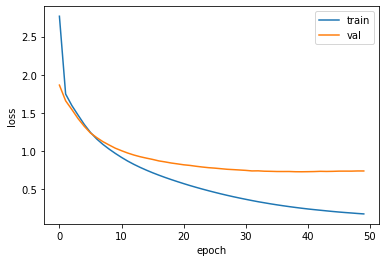

In [47]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

# Step 6. 모델 평가하기
---

In [48]:
# 인코더
encoder_model = Model(encoder_inputs, encoder_states)

# 디코더
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h,decoder_state_input_c]

# 훈련 때 사용했던 임베딩 layer 재사용
dec_emb2 = Embedding(fra_vocab_size,hidden_units)(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해 단어 예측
decoder_outputs2 = decoder_softmax_layer(decoder_outputs2)

# 디코더 수정
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                     [decoder_outputs2] + decoder_states2)

In [49]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <sos>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1)) 
    target_seq[0, 0] = fra_to_index['<sos>']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)  # (1,1,단어 사전 갯수) 추출

        # 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) # 한줄로 만들어줌 차원 축소
        sampled_char = index_to_fra[sampled_token_index]
        
        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' ' + sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '<eos>' or
            len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True
        
        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장     
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [50]:
def seq_to_eng(input_seq):
    sentence = ''
    for encoded_word in input_seq:
        if (encoded_word != 0):
            sentence += index_to_eng[encoded_word] + ' '
    return sentence

def seq_to_fra(input_seq):
    sentence = ''
    for encoded_word in input_seq:
        if (encoded_word != 0 and encoded_word != fra_to_index['<sos>'] and encoded_word != fra_to_index['<eos>']):
            sentence += index_to_fra[encoded_word] + ' '
    return sentence

In [51]:
encoder_input_train[30: 30+1]

array([[ 27,  11,  30, 474,   0,   0,   0]], dtype=int32)

In [55]:
for seq_index in [3,48,1138,1576,1895,2095]:
    input_seq = encoder_input_train[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    
    print("입력문장 :", seq_to_eng(encoder_input_train[seq_index]))
    print("정답문장 :", seq_to_fra(decoder_input_train[seq_index]))
    print("번역문장 :", decoded_sentence[1:-5])
    print("-"*50)

입력문장 : tom talks tough 
정답문장 : tom parle comme un dur 
번역문장 : tom que que 
--------------------------------------------------
입력문장 : i ll go if you go 
정답문장 : je partirai si tu le fais 
번역문장 : je je je 
--------------------------------------------------
입력문장 : listen carefully 
정답문장 : ecoutez attentivement 
번역문장 : ecoute ecou
--------------------------------------------------
입력문장 : look at the meter 
정답문장 : regarde le compteur 
번역문장 : regarde re
--------------------------------------------------
입력문장 : tom wake up 
정답문장 : reveille toi tom ! 
번역문장 : reveille tom ! 
--------------------------------------------------
입력문장 : have a nice trip ! 
정답문장 : bon voyage ! 
번역문장 : un une ! ! ! 
--------------------------------------------------


In [79]:
for seq_index in [3,50,100,300,1001]:
    input_seq = encoder_input_val[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    
    print("입력문장 :", seq_to_eng(encoder_input_train[seq_index]))
    print("정답문장 :", seq_to_fra(decoder_input_train[seq_index]))
    print("번역문장 :", decoded_sentence[1:-5])
    print("-"*50)

입력문장 : tom talks tough 
정답문장 : tom parle comme un dur 
번역문장 : tom a 
--------------------------------------------------
입력문장 : we understand 
정답문장 : nous comprenons 
번역문장 : sois un to
--------------------------------------------------
입력문장 : they re similar 
정답문장 : elles sont similaires 
번역문장 : je me ca 
--------------------------------------------------
입력문장 : i have blonde hair 
정답문장 : j ai les cheveux blonds 
번역문장 : je me ca 
--------------------------------------------------
입력문장 : who believes that ? 
정답문장 : qui croit ca ? 
번역문장 : c trop trop 
--------------------------------------------------


# 회고

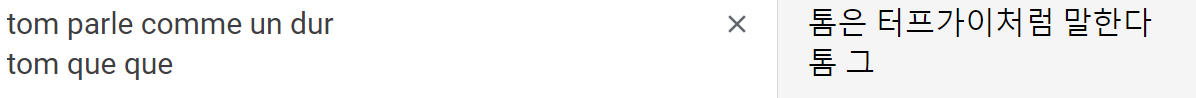

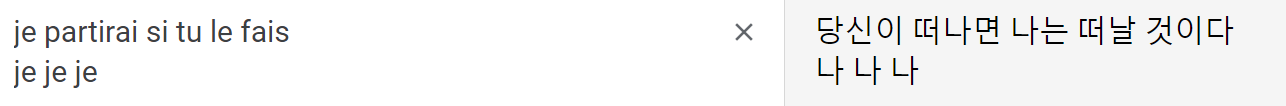

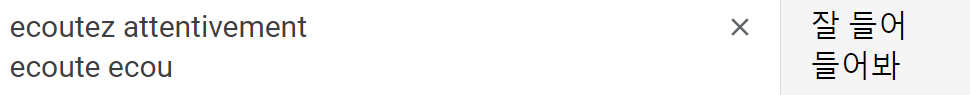

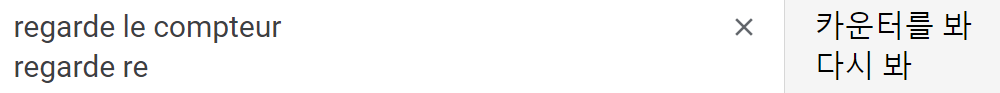

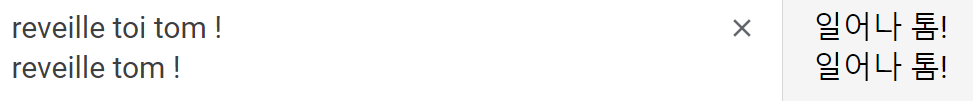


위에서 부터 차례대로 위의 정답문장과, 번역문장 구글 번역기로 돌려봄

---

이번엔 모델을 구성하고 예측을 하는 과정이 조금 특이했다. 먼저 인코딩을 위해 만든 모델에서 마지막에 LSTM으로 뽑은 output과 state를 decoding을 위해 만든 모델에 넣어주어야 한다는 것. 그리고 디코딩 모델에 예측값이 아닌 target 값을 넣어줘서 정답률을 올려준다.

예측과정에서는 주제를 던져주고 작사를 하는 모델 처럼 입력문이 들어왔을 때 이를 초반 시작 문자가 들어가고부터 단어를 하나씩 예측한다.
다만 실험 결과 초반에 들어간 단어 I,Me,You,We 등의 주어나, 명령문으로 시작하는 문장에 대해서 첫글자는 굉장히 잘 맞추는 경향을 보인다.
하지만 글이 길어지고 동사가 주어 다음에 있을 때는 동사를 잘 맞추지 못했다. 몇몇 변역문 중에 처음 주어를 3번 반복해서 예상 문장이 만들어지는 것을 보면 예상하기로 모델이 이 전 단어에 대한 영향을 너무 많이 받고 있는 것이 아닌가 한다. 차차 알아가 봐야할 것 같다.


그리고 빈번하게 등장하는 단어에 대해서는 잘 맞추고 잘 나타나지 않는 희소 단어들을 정확하게 맞추지는 못한 것 같다. 당연한 말이지만 더 큰 단어집, 더 많은 sample을 사용한다면 더 정확히 맞출 수 있지 않을 까 합니다.

그리고 또 한가지 unicodedata를 통해 문자열의 악센트만 지우고 알파벳으로 치환 시킬 수 있다는 것을 알았다.

## 참고 문헌

- accent 제거
https://python.flowdas.com/library/unicodedata.html

https://blog.naver.com/boaconic3769/222665444079


- 번역기 만들기 a부터 z 까지
https://wikidocs.net/86900